In [3]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [4]:
DATA_BASE_PATH = "../data/m5-forecasting-accuracy/"
SALES_EVALUATION = "sales_train_evaluation.csv"
SALES_VALIDATION = "sales_train_validation.csv"
CALENDAR = "calendar.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"
SELL_PRICES = "sell_prices.csv"

DAYS: int = 28

In [5]:
def _down_cast(df):
    """ reduce memory usage """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [6]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

In [7]:
def data_preprocessing(df):
    df = pd.melt(
        frame=df, 
        id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name="d", 
        value_name="sold"
    )
    df = pd.merge(
        left=df, 
        right=calendar, 
        how="left", 
        on="d"
    )
    df = pd.merge(
        left=df, 
        right=sell_prices, 
        on=["store_id", "item_id", "wm_yr_wk"], 
        how="left"
    )
    release_dates = sell_prices.groupby(["store_id", "item_id"])["wm_yr_wk"].agg(["min"]).reset_index()
    release_dates.columns = ["store_id", "item_id", "release"]
    df = pd.merge(
        left=df,
        right=release_dates, 
        how="left", 
        on=["store_id", "item_id"]
    )
    return df

In [8]:
df = data_preprocessing(sales_validation)
df = df[df['wm_yr_wk'] >= df['release']]

In [9]:
df['sell_price'] = df['sell_price'].astype(np.float32)

In [10]:
AGG_LEVEL_COLUMNS = {
    "Level1": [], # no grouping, sum of all
    "Level2": ['state_id'],
    "Level3": ['store_id'],
    "Level4": ['cat_id'],
    "Level5": ['dept_id'],
    "Level6": ['state_id', 'cat_id'],
    "Level7": ['state_id', 'dept_id'],
    "Level8": ['store_id', 'cat_id'],
    "Level9": ['store_id', 'dept_id'],
    "Level10": ['item_id'],
    "Level11": ['state_id', 'item_id'],
    "Level12": ['item_id','store_id'],
}

# for i, agg_level in enumerate(list(AGG_LEVEL_COLUMNS.keys())[1:]):
#     # print(agg_level)
#     print(agg_level, df.groupby(AGG_LEVEL_COLUMNS[agg_level]).ngroups)
#     sums = df.groupby(AGG_LEVEL_COLUMNS[agg_level] + ['d'])['sold'].sum().reset_index(drop=False)
#     means = sums.groupby(AGG_LEVEL_COLUMNS[agg_level])['sold'].mean()
    
#     if i > 8:
#         plt.hist(means, bins = 40) 
#     else:
#         plt.hist(means)
#     plt.show()

In [11]:
# df['date'].min(), df['date'].max()
df.head(5)

id        item_id    dept_id   cat_id store_id  \
7   HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8   HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9   HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   
11  HOBBIES_1_012_CA_1_validation  HOBBIES_1_012  HOBBIES_1  HOBBIES     CA_1   
14  HOBBIES_1_015_CA_1_validation  HOBBIES_1_015  HOBBIES_1  HOBBIES     CA_1   

   state_id    d  sold       date  wm_yr_wk  ...  year  event_name_1  \
7        CA  d_1    12 2011-01-29     11101  ...  2011           NaN   
8        CA  d_1     2 2011-01-29     11101  ...  2011           NaN   
9        CA  d_1     0 2011-01-29     11101  ...  2011           NaN   
11       CA  d_1     0 2011-01-29     11101  ...  2011           NaN   
14       CA  d_1     4 2011-01-29     11101  ...  2011           NaN   

    event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  \
7            NaN           NaN          NaN       0       0       0   
8            NaN           NaN          NaN       0       0       0   
9            NaN           NaN          NaN       0       0       0   
11           NaN           NaN          NaN       0       0       0   
14           NaN           NaN          NaN       0       0       0   

    sell_price  release  
7     0.459961    11101  
8     1.559570    11101  
9     3.169922    11101  
11    5.980469    11101  
14    0.700195    11101  

[5 rows x 23 columns]

# Plots to Provide Impression of Series

### Plot Example Series at Lowest Level

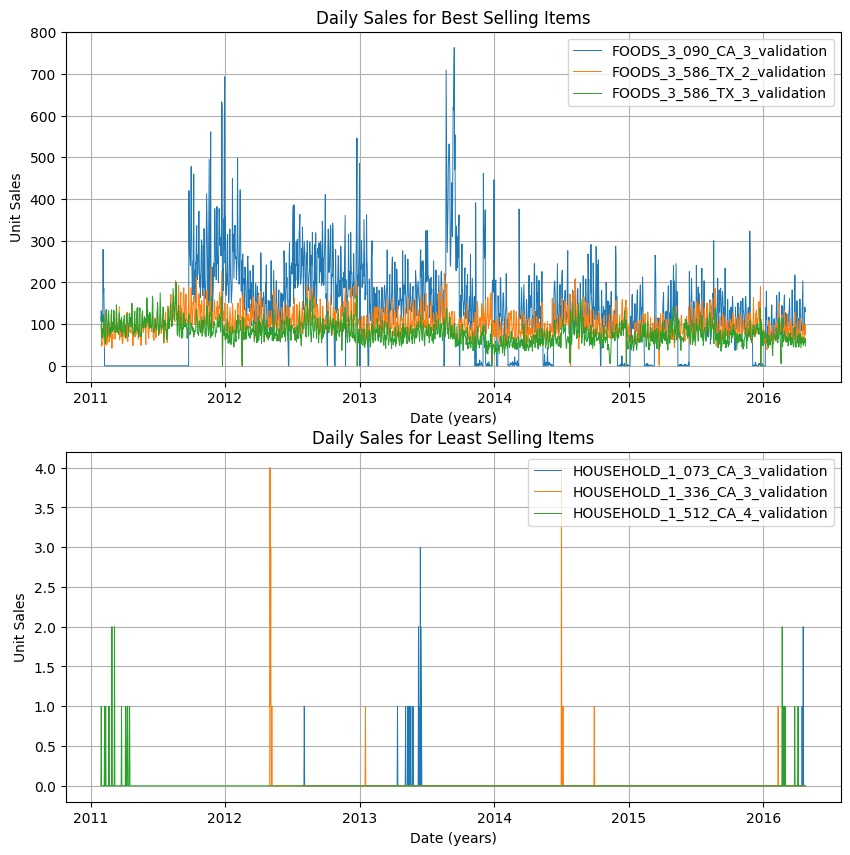

In [13]:
idx_sorted = df.groupby('id')['sold'].mean().sort_values().reset_index(drop=False)['id']
# 3 lowest selling series
examples_low = idx_sorted.values[:3]
# 3 highest selling series
examples_high = idx_sorted.values[-3:]

fig, axs = plt.subplots(2,1, figsize = (10,10))
axs[0].set_title('Daily Sales for Best Selling Items')
axs[1].set_title('Daily Sales for Least Selling Items')

# HIGHEST SELLER AVG
# low_example = FOODS_3_090_CA_3_validation
ax = axs[0]
for id in examples_high[::-1]:
    df_temp = df[df['id'] == id]
    ax.plot(df_temp['date'], df_temp['sold'], label = str(id), linewidth=.7)

# LOWEST SELLER AVG
# high_example = HOUSEHOLD_1_512_CA_4_validation
ax = axs[1]
for id in examples_low[::-1]:
    df_temp = df[df['id'] == id]
    ax.plot(df_temp['date'], df_temp['sold'], label = str(id), linewidth=.7)

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel('Unit Sales')
    ax.set_xlabel('Date (years)')
    
plt.show()

### Plot Example Series at Higher Aggregated Levels

In [107]:
agg_columns = []
def plot_higher_aggregated_level(df, agg_columns, plot_low = True):
    if len(agg_columns) == 0:
        agg_columns = ['temp_id']
        df['temp_id'] = 'temp_id'
        
    # df = df.groupby(agg_columns+['d'])['sold'].sum().reset_index(drop=False)
    df = df.groupby(agg_columns+['d']).agg({'sold': sum, 'date': 'last'}).reset_index(drop=False)
    df = df.sort_values('date')
    idx_sorted = df.groupby(agg_columns)['sold'].mean().reset_index(drop=False).sort_values('sold').drop('sold', axis=1)
    # 3 lowest selling series
    examples_low = idx_sorted.values[:3]
    # 3 highest selling series
    examples_high = idx_sorted.values[-3:]

    fig, axs = plt.subplots((2 if plot_low else 1),1, figsize = (10,10 if plot_low else 5))
    if not plot_low:
        axs = [axs]
    # axs = [axs] if plot_low else axs
    if agg_columns[0] == 'temp_id':
        agg_string = "Total"
    else:
        agg_string = " + ".join(agg_columns)
    axs[0].set_title(f'Daily Sales for Best Selling Series (Aggregated {agg_string})')
    if plot_low: axs[1].set_title(f'Daily Sales for Least Selling Series (Aggregated {agg_string})')

    # HIGHEST SELLER AVG
    # low_example = FOODS_3_090_CA_3_validation
    ax = axs[0]
    # for id in examples_high[::-1]:
    for row in examples_high:
        if len(agg_columns) == 1:
            idx_temp = df[agg_columns[0]] == row[0]
        else:
            idx_temp = (df[agg_columns[0]] == row[0]) & (df[agg_columns[1]] == row[1])
        df_temp = df[idx_temp]
        ax.plot(df_temp['date'], df_temp['sold'], label = " + ".join(row), linewidth=.7)

    # LOWEST SELLER AVG
    # high_example = HOUSEHOLD_1_512_CA_4_validation
    if plot_low:
        ax = axs[1]
        for row in examples_low[::-1]:
            if len(agg_columns) == 1:
                idx_temp = df[agg_columns[0]] == row[0]
            else:
                idx_temp = (df[agg_columns[0]] == row[0]) & (df[agg_columns[1]] == row[1])
            df_temp = df[idx_temp]
            ax.plot(df_temp['date'], df_temp['sold'], label = " + ".join(row), linewidth=.7)
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set_ylabel('Unit Sales')
        ax.set_xlabel('Date (years)')
    fig.tight_layout()
    plt.show()

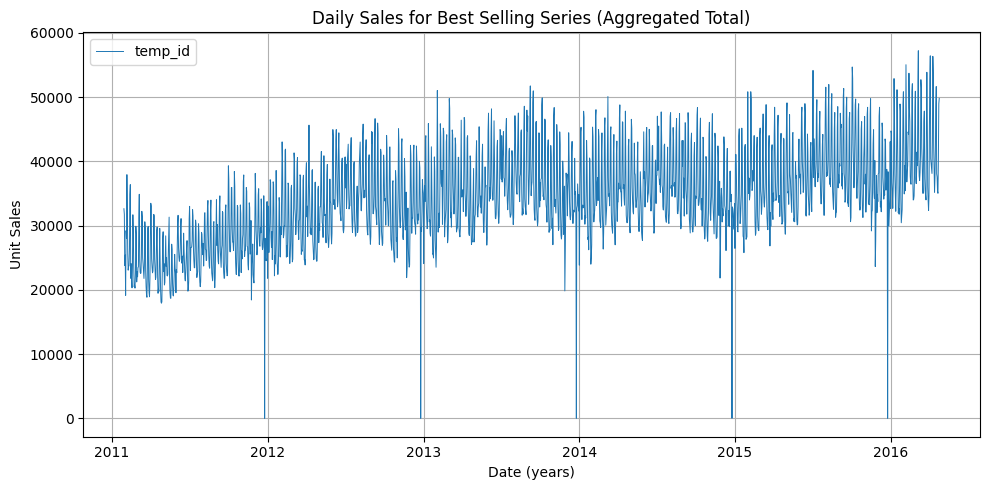

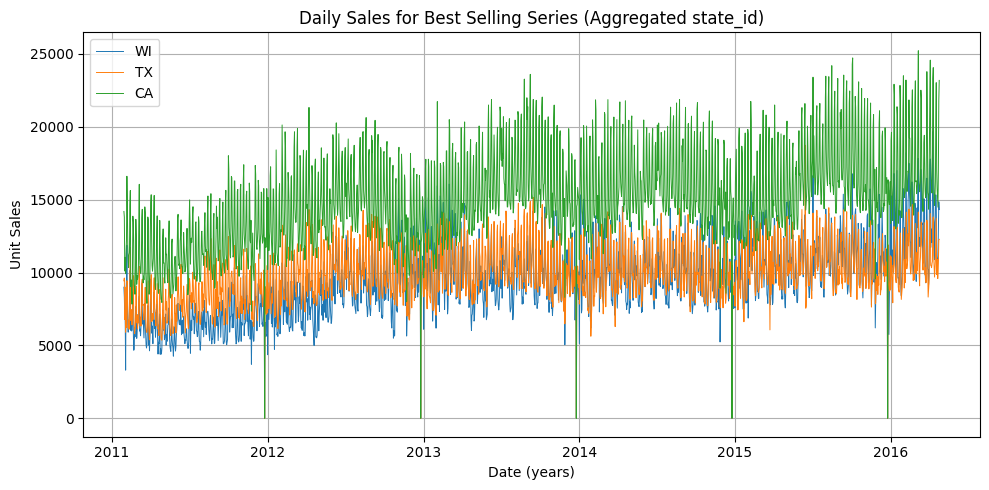

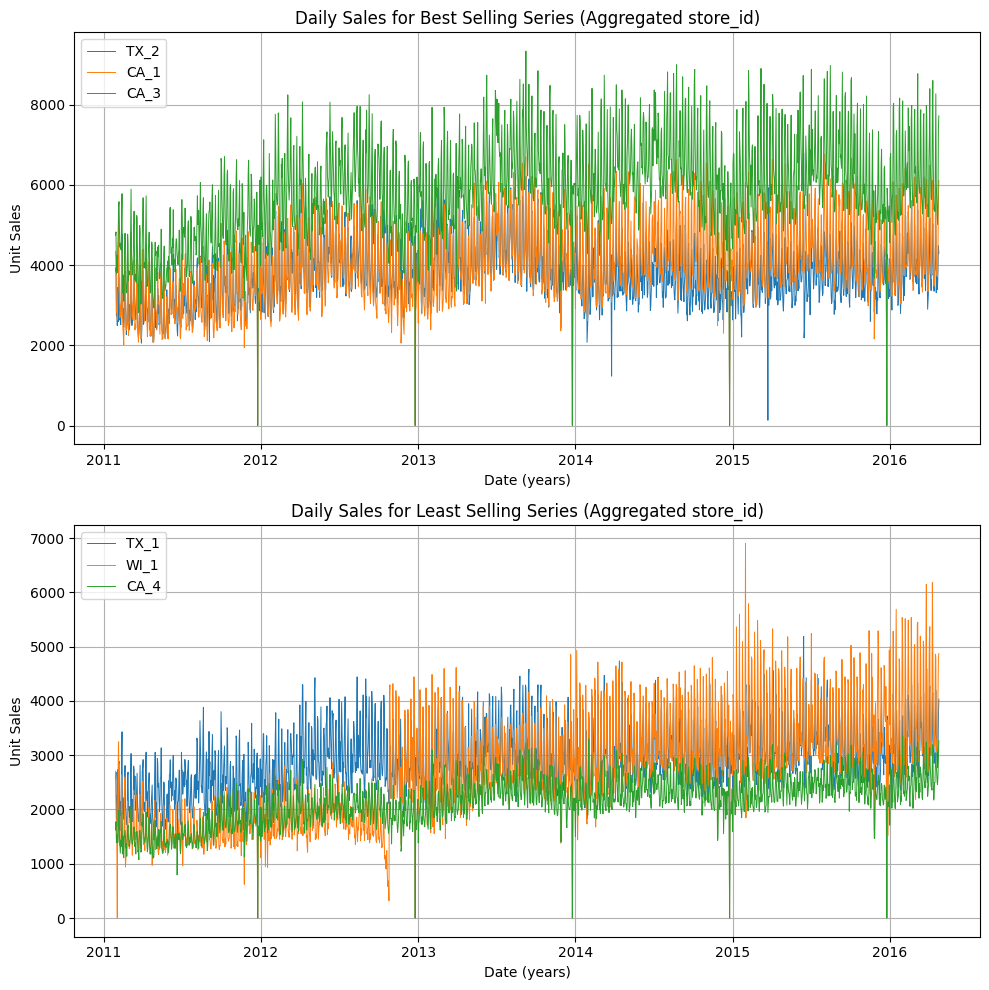

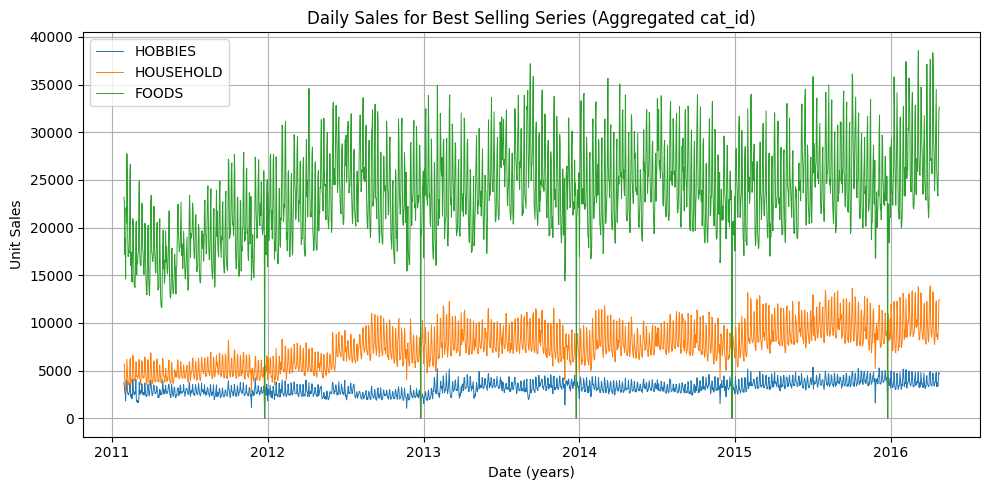

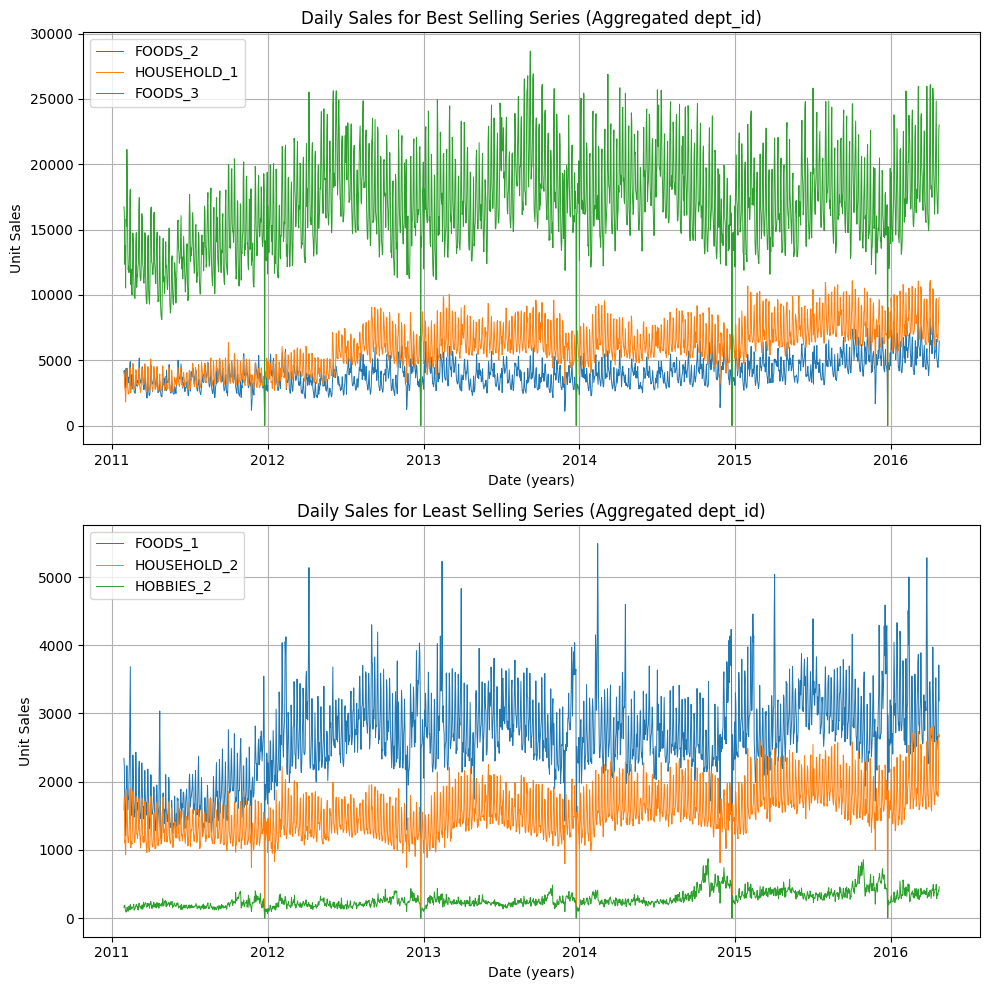

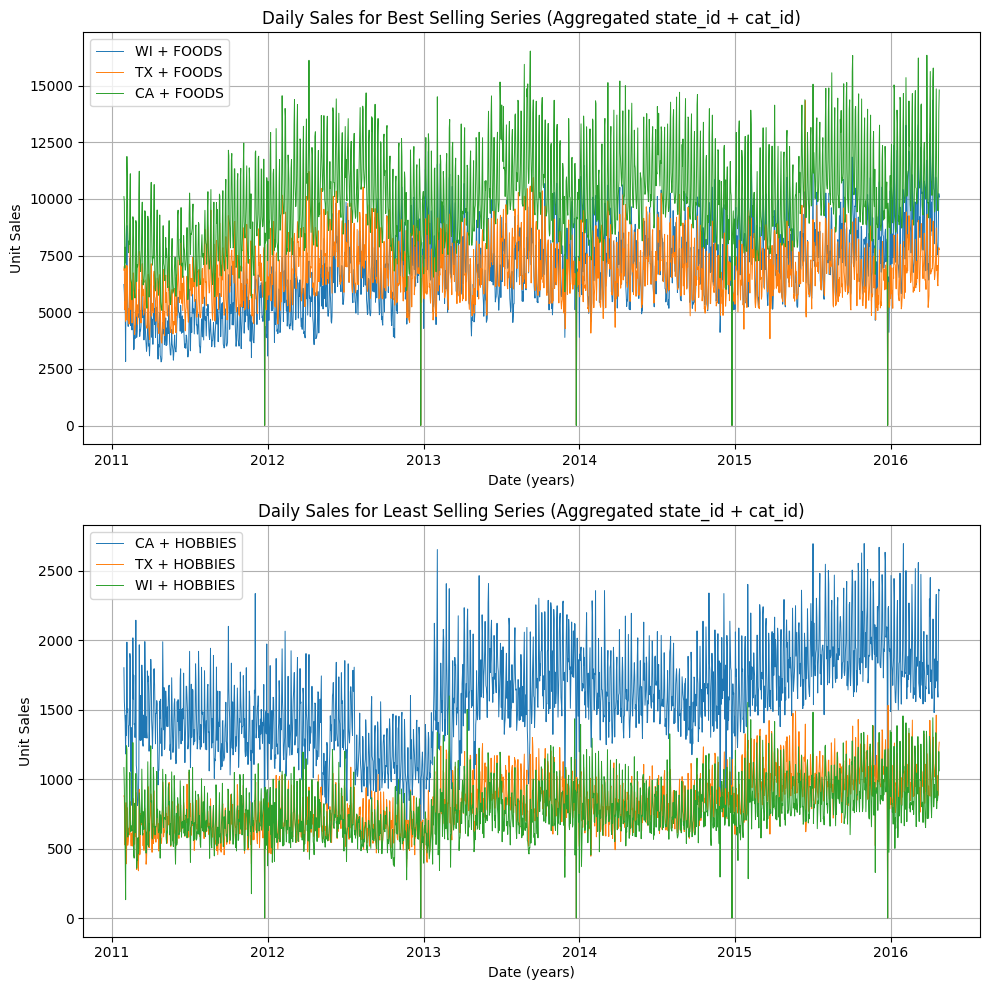

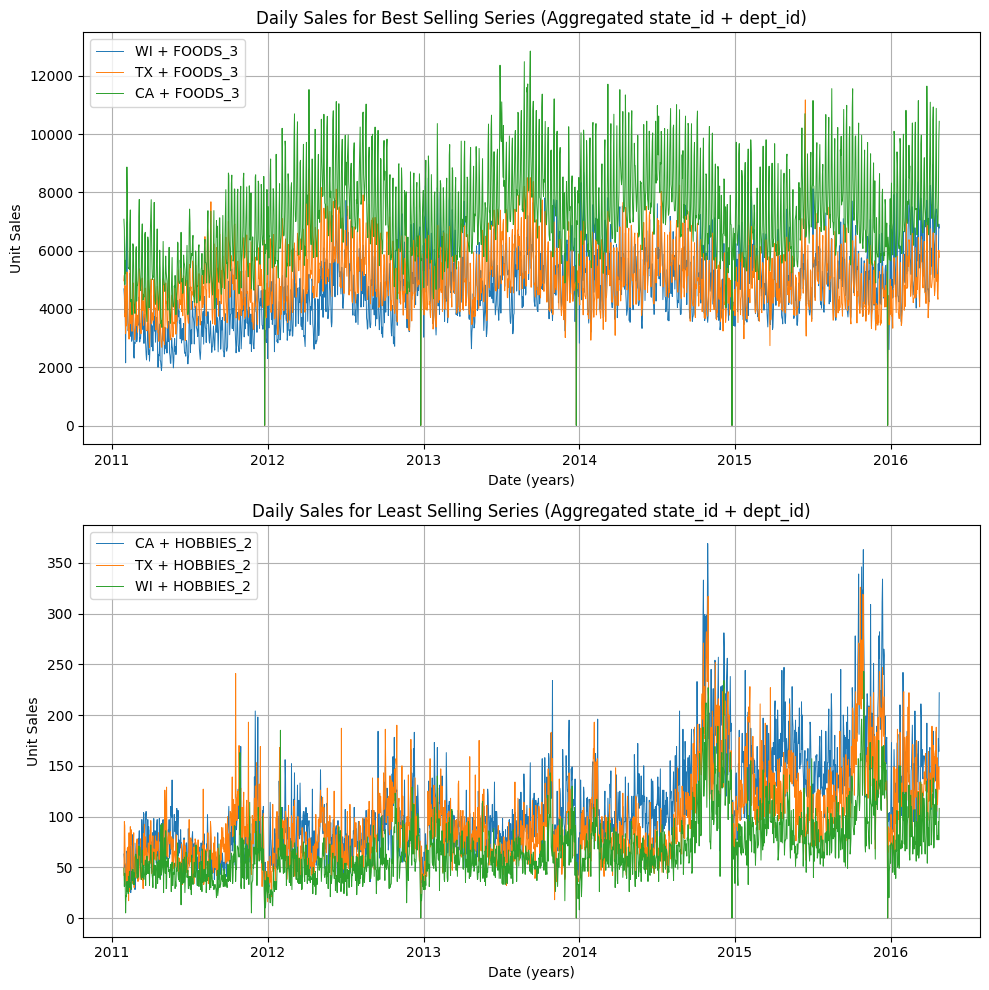

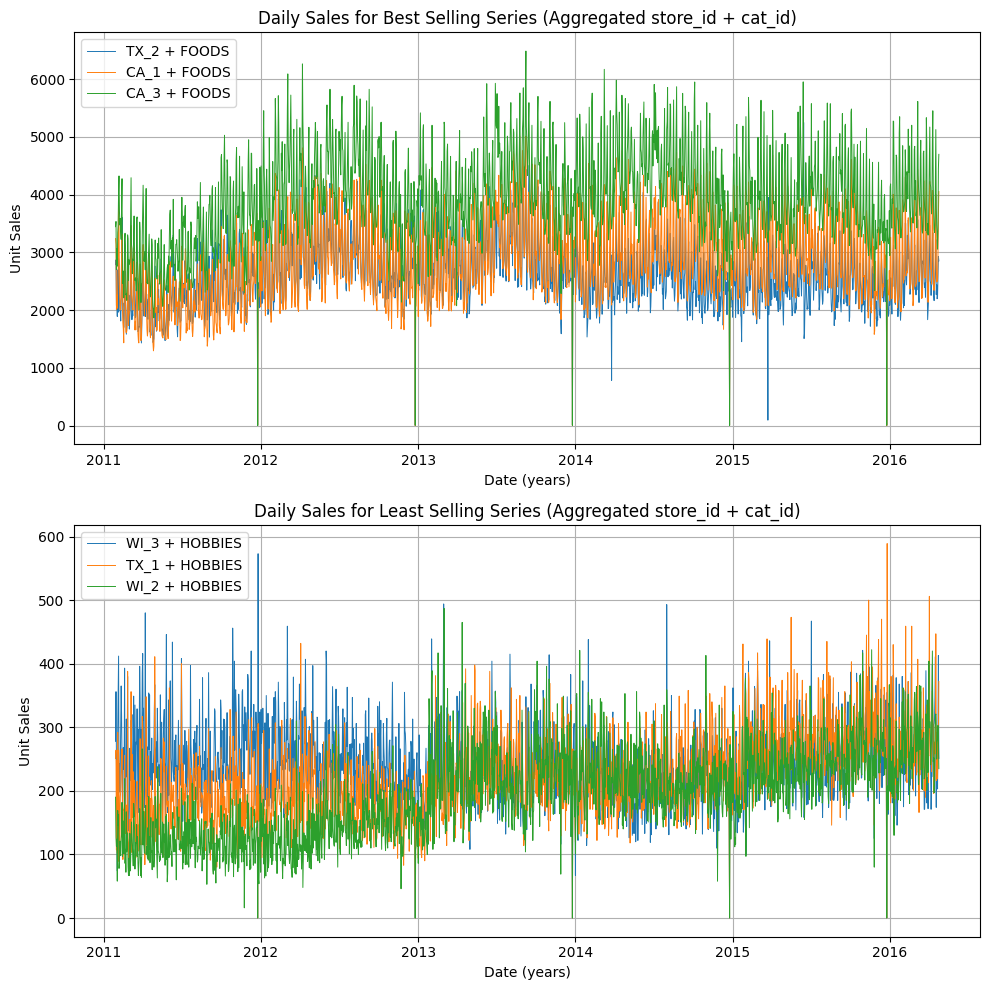

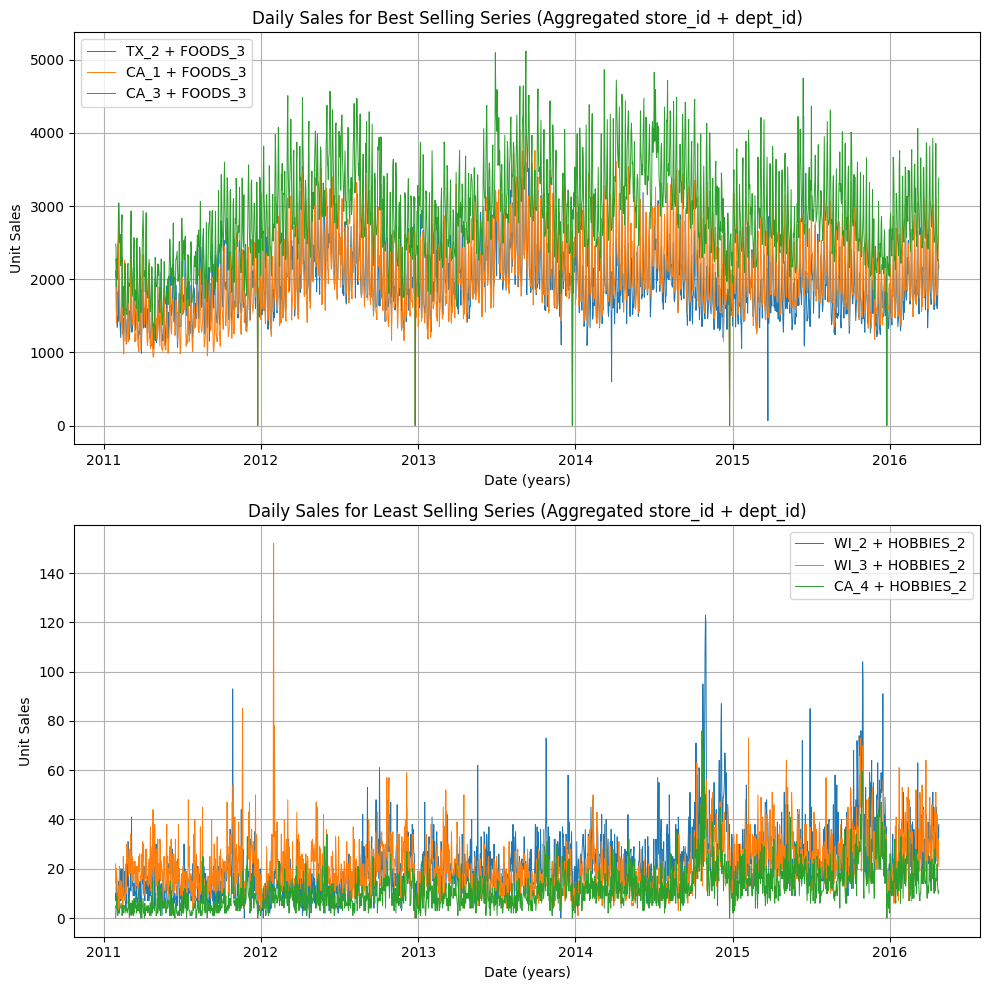

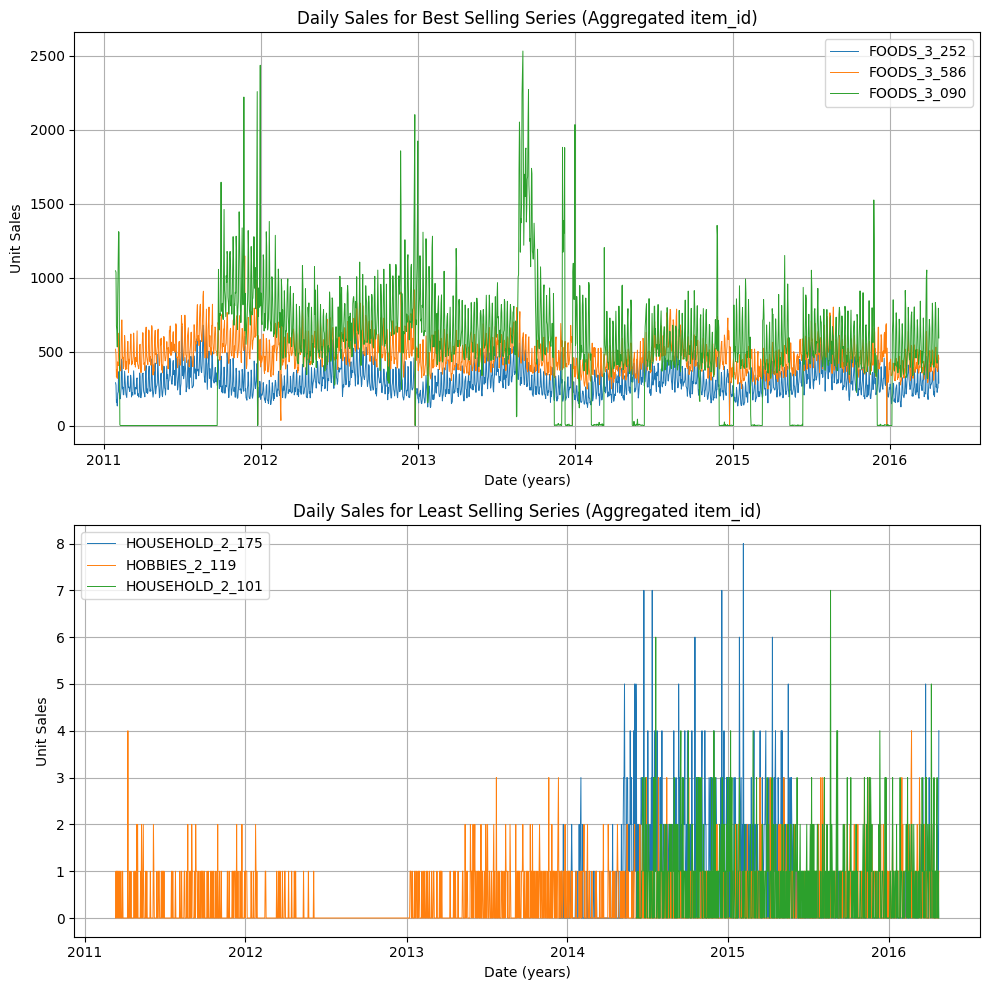

In [108]:
plot_higher_aggregated_level(df.copy(), [], False)
plot_higher_aggregated_level(df.copy(), ['state_id'], False)
plot_higher_aggregated_level(df.copy(), ['store_id'])
plot_higher_aggregated_level(df.copy(), ['cat_id'], False)
plot_higher_aggregated_level(df.copy(), ['dept_id'])
plot_higher_aggregated_level(df.copy(), ['state_id', 'cat_id'])
plot_higher_aggregated_level(df.copy(), ['state_id', 'dept_id'])
plot_higher_aggregated_level(df.copy(), ['store_id', 'cat_id'])
plot_higher_aggregated_level(df.copy(), ['store_id', 'dept_id'])
plot_higher_aggregated_level(df.copy(), ['item_id'])

# Plot Seasonality

### Plot Sales Weekday

2023-11-23 23:56:01 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-23 23:56:01 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


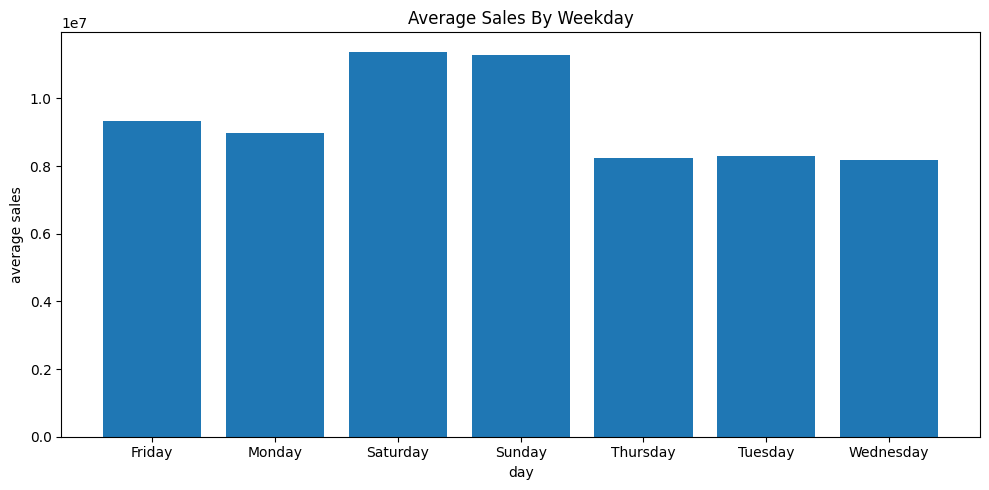

In [109]:
# average over all stores
sales_by_weekday = df.groupby(["weekday"]).agg({"sold": np.sum}).reset_index(drop=False)
fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.bar(sales_by_weekday.weekday, sales_by_weekday.sold)

axs.set_title("Average Sales By Weekday")
axs.set_xlabel("day")
axs.set_ylabel("average sales")
fig.tight_layout()
plt.show()

### Plot Sales Monthday

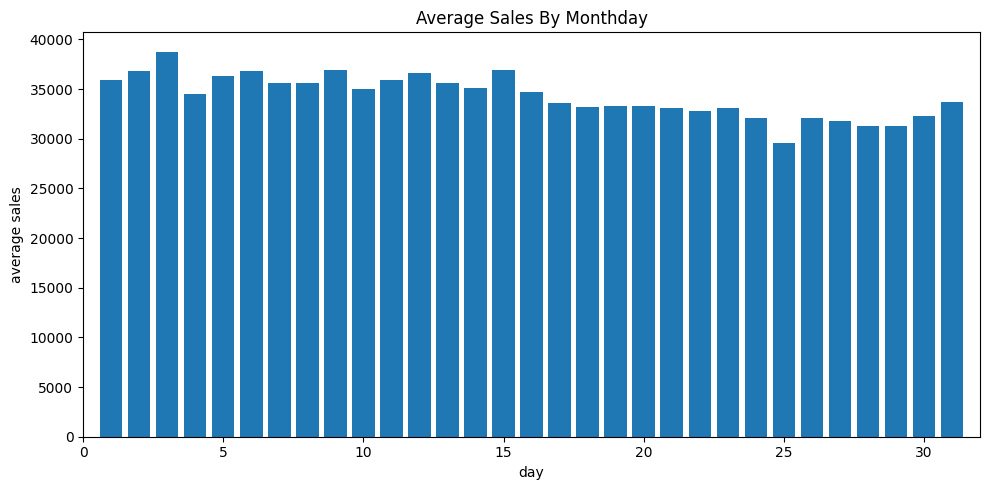

                            OLS Regression Results                            
Dep. Variable:                   sold   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     123.5
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           7.48e-28
Time:                        23:56:03   Log-Likelihood:                -19683.
No. Observations:                1913   AIC:                         3.937e+04
Df Residuals:                    1911   BIC:                         3.938e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.757e+04    333.237    112.752      0.0

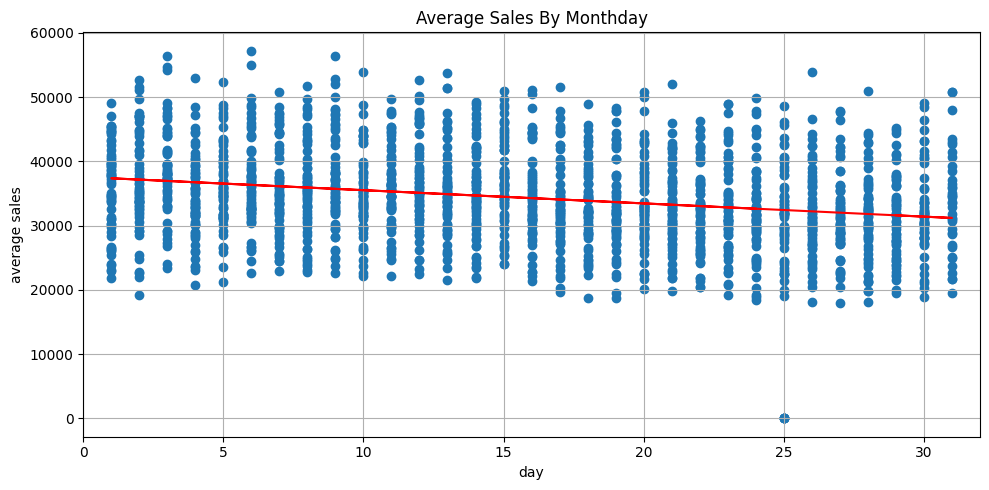

In [110]:
df['monthday'] = df['date'].dt.day
sales_total = df.groupby('date').agg({'sold': np.sum, 'monthday': 'last'}).reset_index(drop=False)
sales_by_monthday = sales_total.groupby('monthday').agg({"sold": np.mean}).reset_index(drop=False)

fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.bar(sales_by_monthday.monthday, sales_by_monthday.sold)

axs.set_title("Average Sales By Monthday")
axs.set_xlabel("day")
axs.set_ylabel("average sales")
axs.set_xlim(0,32)
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1,1, figsize = (10, 5))
# axs.bar(sales_by_monthday.monthday, sales_by_monthday.sold)
axs.scatter(sales_total.monthday, sales_total.sold)
import statsmodels.api as sm
model = sm.OLS(sales_total.sold, sm.add_constant(sales_total.monthday))
results = model.fit()
print(results.summary())
axs.plot(sales_total.monthday, results.predict(sm.add_constant(sales_total.monthday)), 'r')
axs.grid()
axs.set_title("Average Sales By Monthday")
axs.set_xlabel("day")
axs.set_ylabel("average sales")
axs.set_xlim(0,32)
fig.tight_layout()
plt.show()

### Plot Seasonal Month

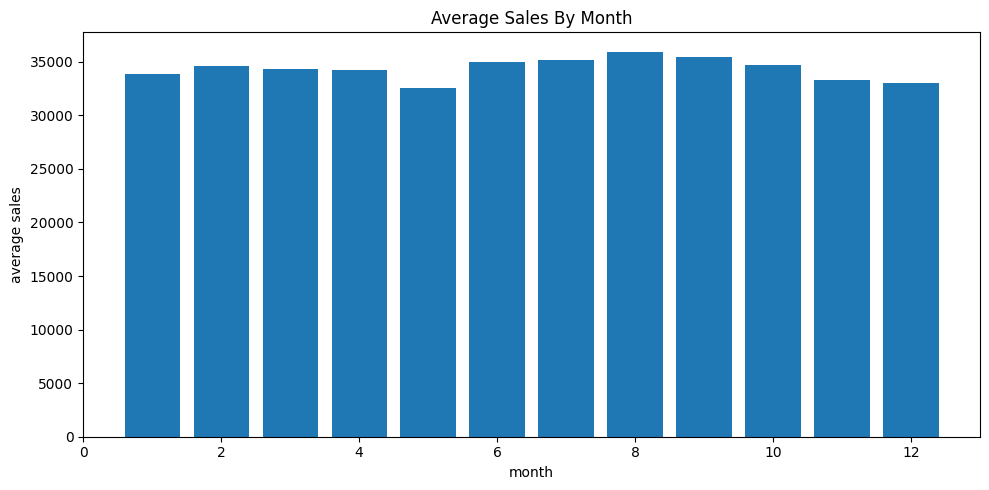

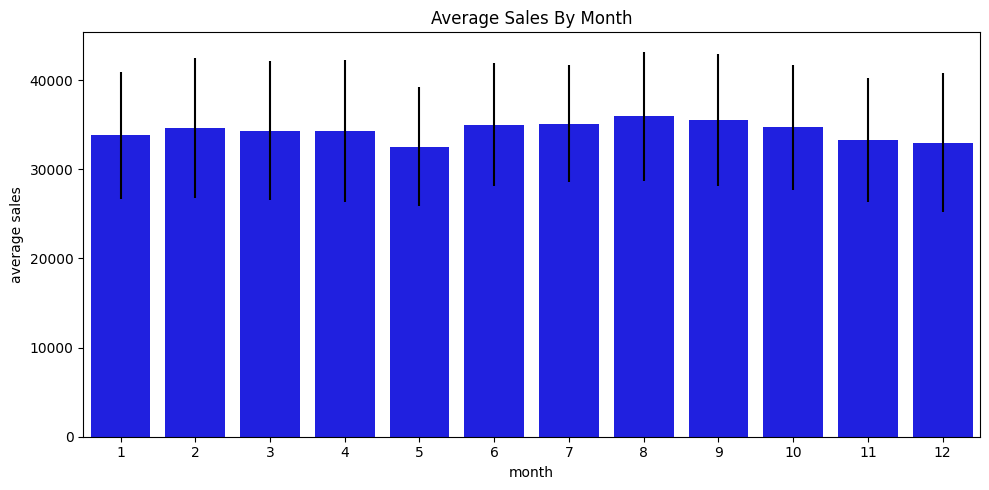

In [111]:
sales_total = df.groupby('date').agg({'sold': np.sum, 'month': 'last'}).reset_index(drop=False)
sales_by_month = sales_total.groupby('month').agg({"sold": np.mean}).reset_index(drop=False)
sales_by_month_std = sales_total.groupby('month').agg({"sold": np.std}).reset_index(drop=False)

fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.bar(sales_by_month.month, sales_by_month.sold, )
axs.set_title("Average Sales By Month")
axs.set_xlabel("month")
axs.set_ylabel("average sales")
axs.set_xlim(0, 13)
fig.tight_layout()
plt.show()

# Creating the bar plot with error bars using Seaborn
fig, axs = plt.subplots(1,1, figsize = (10, 5))
sns.barplot(x=sales_by_month.month, y=sales_by_month.sold, ci="sd", yerr=sales_by_month_std.sold, capsize=0.1, ax=axs, color='blue')
axs.set_title("Average Sales By Month")
axs.set_xlabel("month")
axs.set_ylabel("average sales")
# axs.set_xlim(0, 13)
fig.tight_layout()
plt.show()

# fig, axs = plt.subplots(1,1, figsize = (10, 5))
# # axs.bar(sales_by_monthday.monthday, sales_by_monthday.sold)
# axs.scatter(sales_total.month, sales_total.sold)
# import statsmodels.api as sm
# model = sm.OLS(sales_total.sold, sm.add_constant(sales_total.month))
# results = model.fit()
# print(results.summary())
# axs.plot(sales_total.month, results.predict(sm.add_constant(sales_total.month)), 'r')
# axs.grid()
# axs.set_title("Average Sales By Month")
# axs.set_xlabel("day")
# axs.set_ylabel("average sales")
# axs.set_xlim(0,13)
# plt.show()

### Plot Increase in Sales Over Time

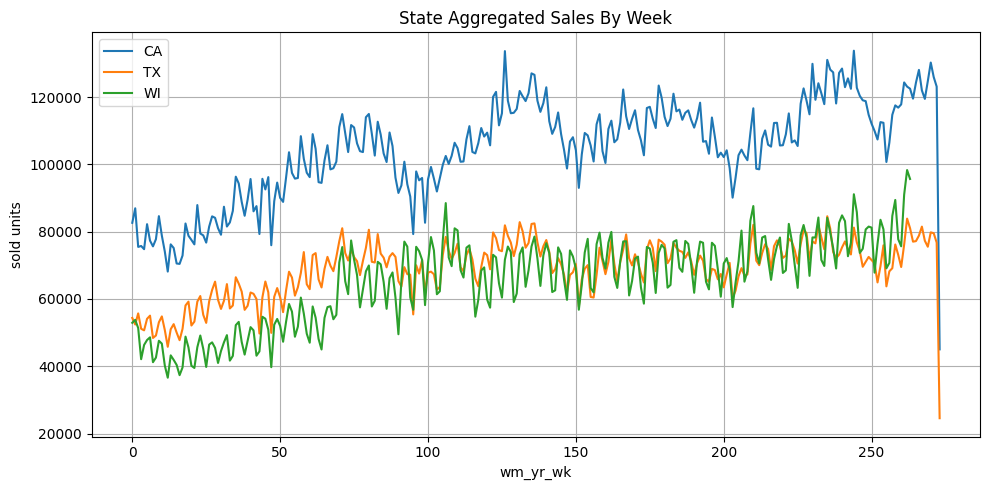

In [143]:
sales_by_store_and_date = df.groupby(["state_id", "wm_yr_wk"]).agg({"sold": np.sum, "date": "first"}).reset_index(drop=False)#["sold"].sum().reset_index(drop=False)
idx_keep = 
sales_by_store_and_date = sales_by_store_and_date[idx_keep]

fig, axs = plt.subplots(1,1, figsize = (10,5))
for state in df.state_id.unique():
    axs.plot(sales_by_store_and_date[sales_by_store_and_date.state_id == state]["sold"].reset_index(drop=True), label = state)

axs.set_title("State Aggregated Sales By Week")
axs.set_xlabel("wm_yr_wk")
axs.set_ylabel("sold units")
axs.legend()
axs.grid();fig.tight_layout()
plt.show()

# Differences Across Stores

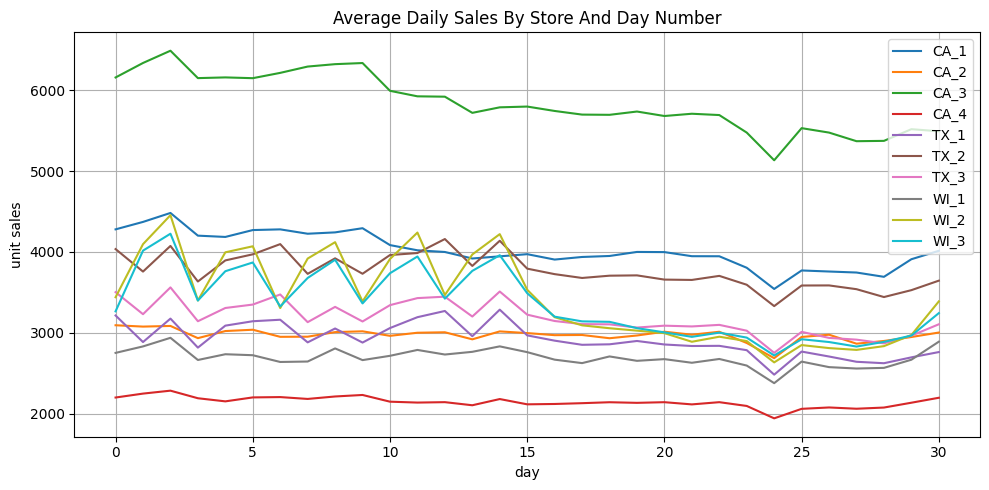

In [114]:
df_c = df.copy()
df_c["day"] = df_c.date.dt.day
sales_aggregated_by_day = df_c.groupby(["store_id", "d"]).agg({"sold": np.sum, "day": "last"}).reset_index(drop=False)
sales_by_store_and_date = sales_aggregated_by_day.groupby(["store_id", "day"]).agg({"sold": np.mean}).reset_index(drop=False)

fig, axs = plt.subplots(1,1, figsize = (10, 5))
for store in sales_by_store_and_date.store_id.unique():
    sales_by_store_and_date[sales_by_store_and_date.store_id == store].sold.reset_index(drop=True).plot(ax = axs, label = store)

axs.set_title("Average Daily Sales By Store And Day Number")
axs.set_xlabel("day")
axs.set_ylabel("unit sales")
axs.legend()
axs.grid()
fig.tight_layout()
plt.show()

In [116]:
# # grouped by store as well
# sales_by_weekday = df.groupby(["store_id", "weekday"]).agg({"sold": np.sum, "wday": "last"}).reset_index(drop=False).sort_values(by="wday", ascending = True)
# n_stores = sales_by_weekday["store_id"].nunique()

# m = 4
# n =  n_stores // m if n_stores % m == 0 else n_stores // m + 1
# fig, axs = plt.subplots(n,m, figsize = (25, 15))

# for k, store_id in enumerate(sales_by_weekday["store_id"].unique()):
#     ax = axs[k // m, k % m]
#     ax.bar(sales_by_weekday[sales_by_weekday["store_id"] == store_id].weekday, sales_by_weekday[sales_by_weekday["store_id"] == store_id].sold)
#     ax.set_title(f"{store_id}: average daily unit sales")
# fig.tight_layout()
# plt.show()

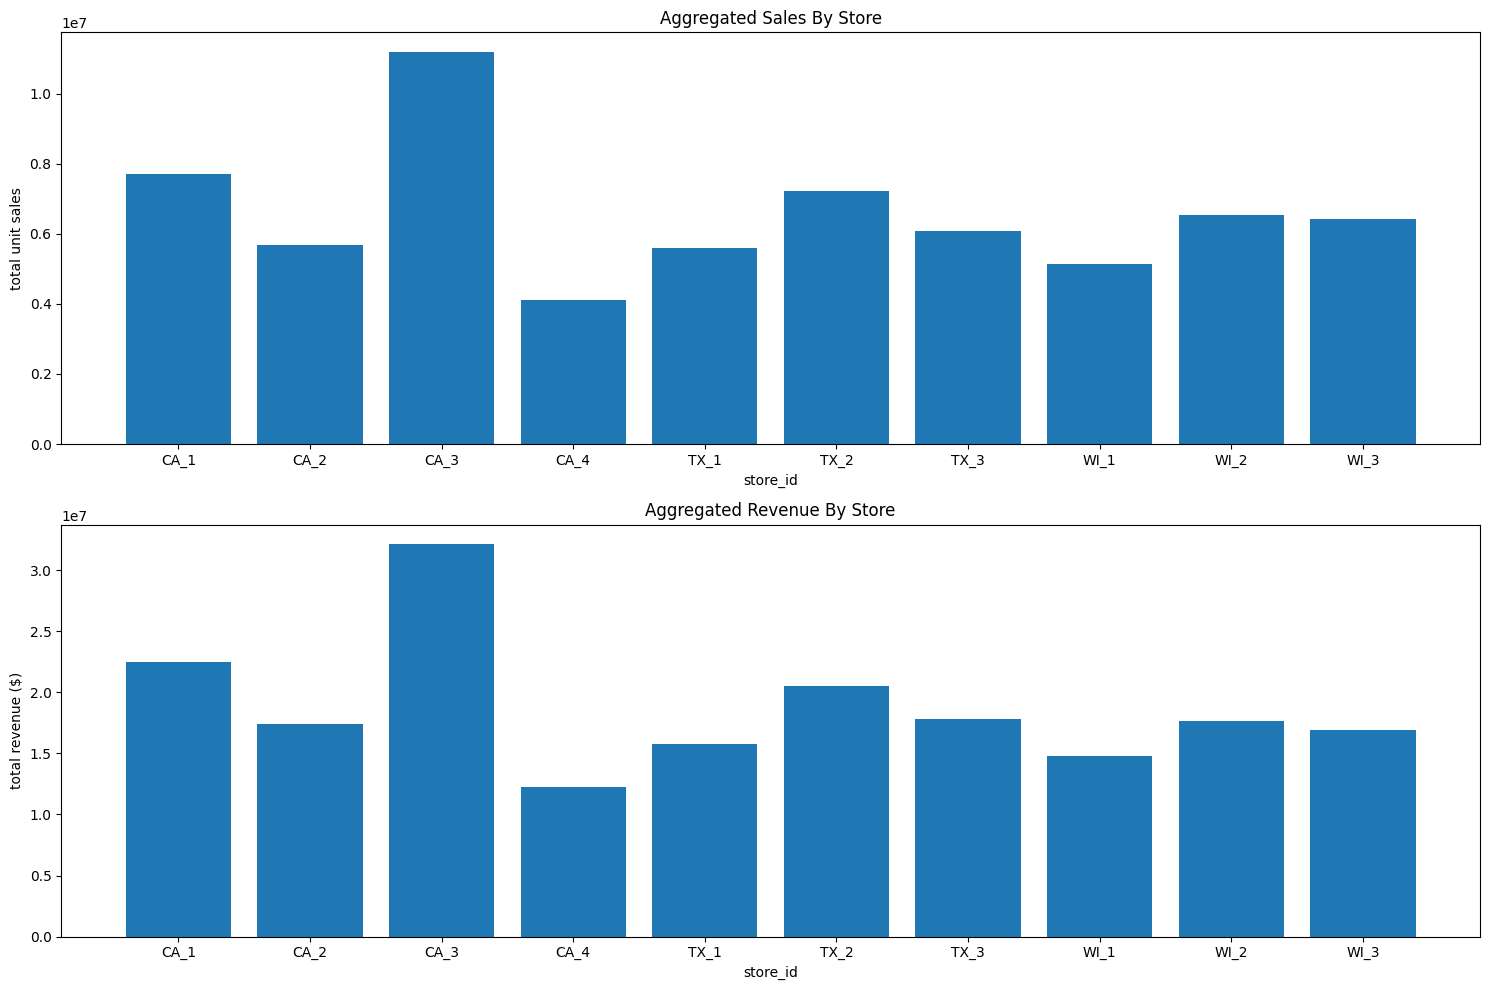

In [117]:
# grouped by store as well
sales_by_store_id = df.groupby(["store_id"]).agg({"sold": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

fig, axs = plt.subplots(2,1, figsize = (15,10))
ax = axs[0]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.sold)
ax.set_title("Aggregated Sales By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total unit sales")

df_c = df.copy()
df_c["sell_price"] = df_c["sell_price"].fillna(0)
df_c["revenue"] = df_c["sold"] * df_c["sell_price"]
sales_by_store_id = df_c.groupby(["store_id"]).agg({"revenue": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

ax = axs[1]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.revenue)
ax.set_title("Aggregated Revenue By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total revenue ($)")
fig.tight_layout()
plt.show()

### Plot Correlation In Sales & Sales Volatility

### Plot Rolling Realized Volatility

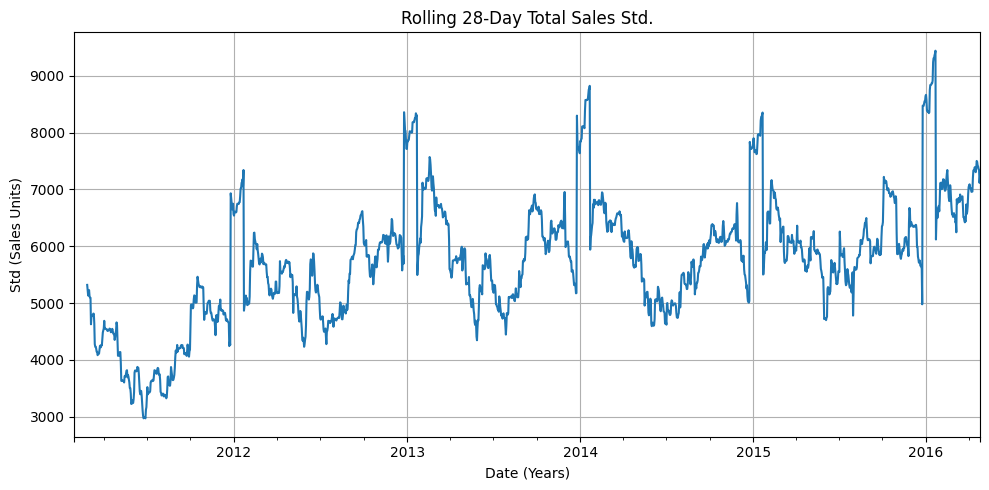

In [131]:
sales_daily_total = df.groupby('date')['sold'].sum()

fig, ax = plt.subplots(1,1, figsize=(10,5))
sales_daily_total.rolling(28).std().plot(ax=ax)

ax.set_title('Rolling 28-Day Total Sales Std.')
ax.set_xlabel('Date (Years)')
ax.set_ylabel('Std (Sales Units)')
ax.grid()
fig.tight_layout()
plt.show()

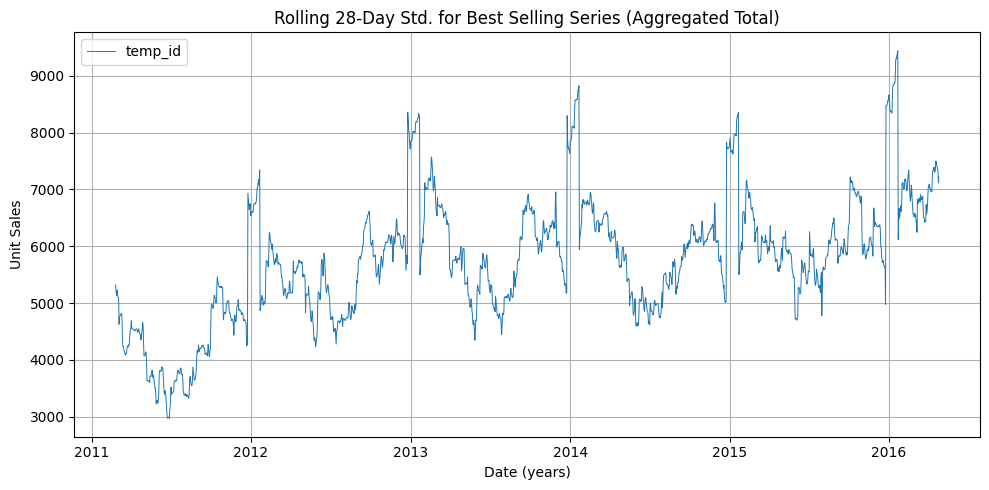

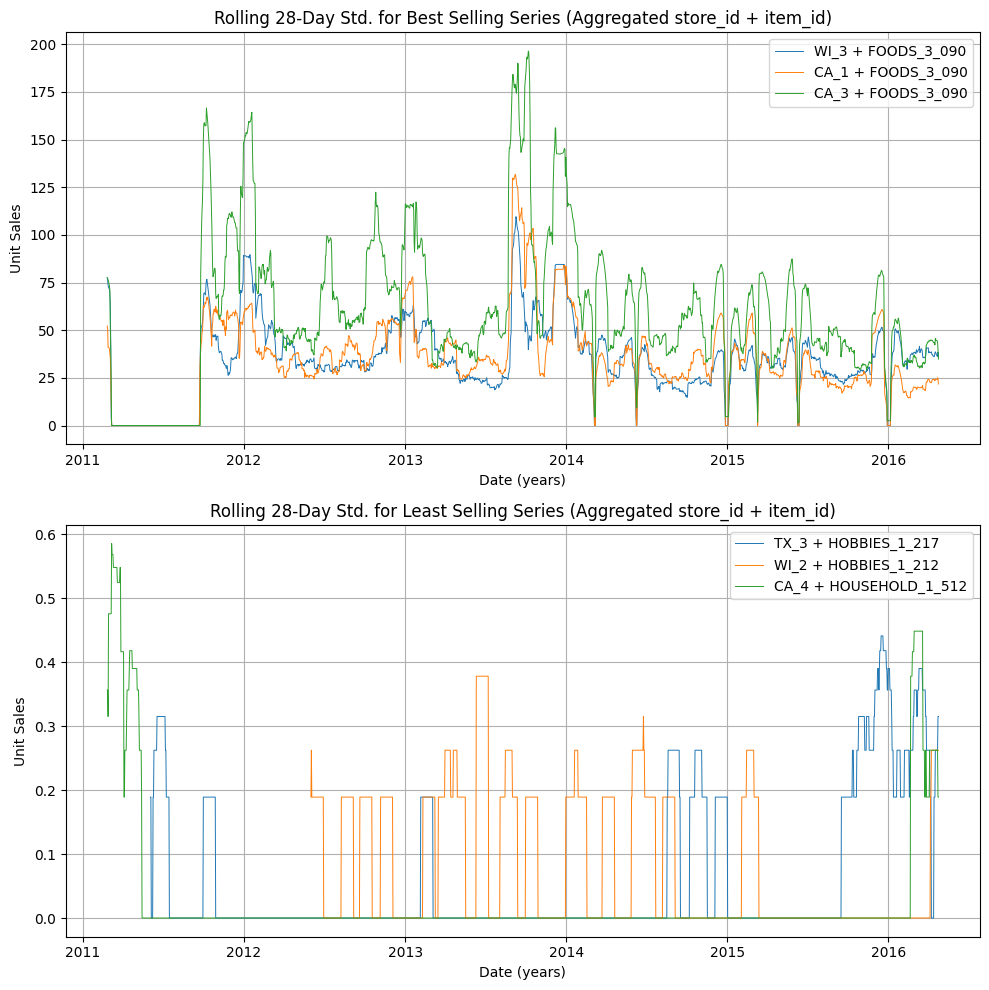

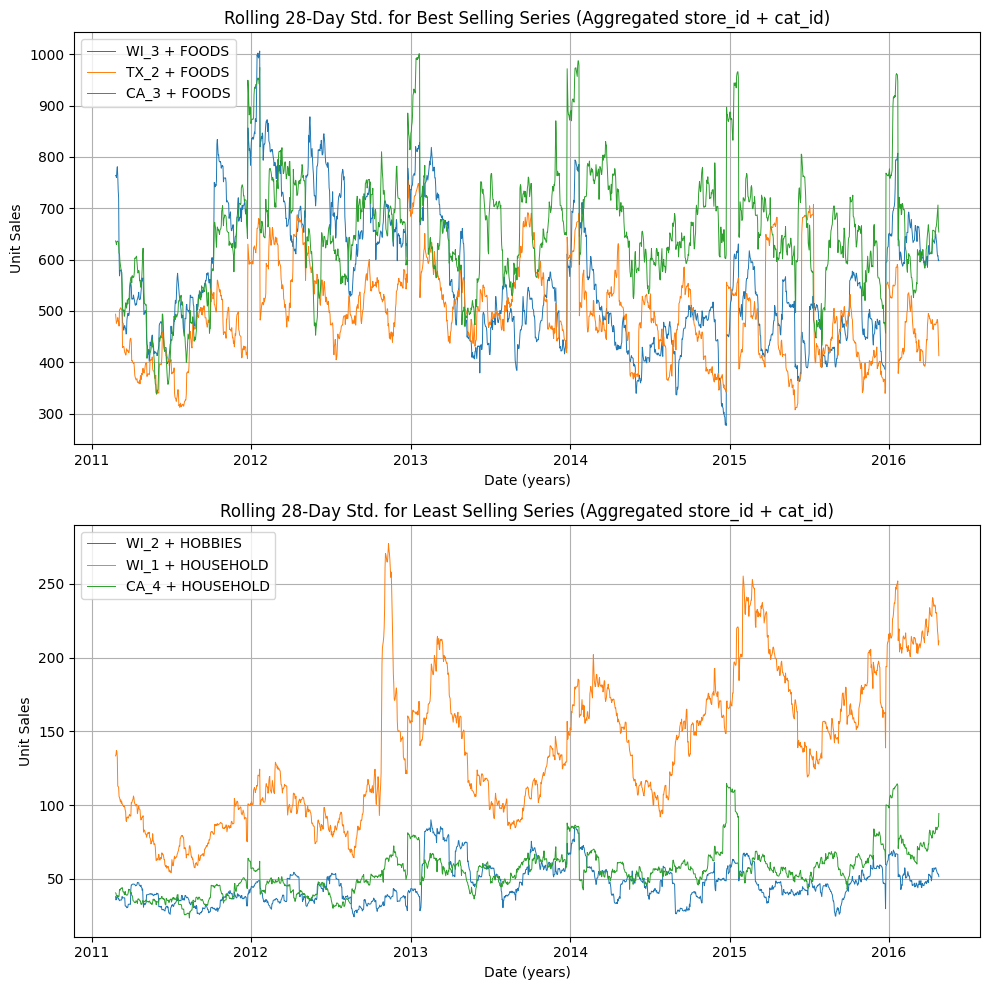

In [132]:
agg_columns = []
def plot_higher_aggregated_level_std(df, agg_columns, plot_low = True):
    if len(agg_columns) == 0:
        agg_columns = ['temp_id']
        df['temp_id'] = 'temp_id'
        
    idx_sorted = df.groupby(agg_columns)['sold'].std().reset_index(drop=False).sort_values('sold').drop('sold', axis=1)
    df = df.groupby(agg_columns+['d']).agg({'sold': sum, 'date': 'last'}).reset_index(drop=False)
    df = df.sort_values('date')
    df['sold'] = df.groupby(agg_columns)['sold'].transform(lambda x: x.rolling(28).std())
    df = df.sort_values('date')
    # 3 lowest selling series
    examples_low = idx_sorted.values[:3]
    # 3 highest selling series
    examples_high = idx_sorted.values[-3:]

    fig, axs = plt.subplots((2 if plot_low else 1),1, figsize = (10,10 if plot_low else 5))
    if not plot_low:
        axs = [axs]
    # axs = [axs] if plot_low else axs
    if agg_columns[0] == 'temp_id':
        agg_string = "Total"
    else:
        agg_string = " + ".join(agg_columns)
    axs[0].set_title(f'Rolling 28-Day Std. for Best Selling Series (Aggregated {agg_string})')
    if plot_low: axs[1].set_title(f'Rolling 28-Day Std. for Least Selling Series (Aggregated {agg_string})')

    # HIGHEST SELLER AVG
    # low_example = FOODS_3_090_CA_3_validation
    ax = axs[0]
    # for id in examples_high[::-1]:
    for row in examples_high:
        if len(agg_columns) == 1:
            idx_temp = df[agg_columns[0]] == row[0]
        else:
            idx_temp = (df[agg_columns[0]] == row[0]) & (df[agg_columns[1]] == row[1])
        df_temp = df[idx_temp]
        ax.plot(df_temp['date'], df_temp['sold'], label = " + ".join(row), linewidth=.7)

    # LOWEST SELLER AVG
    # high_example = HOUSEHOLD_1_512_CA_4_validation
    if plot_low:
        ax = axs[1]
        for row in examples_low[::-1]:
            if len(agg_columns) == 1:
                idx_temp = df[agg_columns[0]] == row[0]
            else:
                idx_temp = (df[agg_columns[0]] == row[0]) & (df[agg_columns[1]] == row[1])
            df_temp = df[idx_temp]
            ax.plot(df_temp['date'], df_temp['sold'], label = " + ".join(row), linewidth=.7)
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set_ylabel('Unit Sales')
        ax.set_xlabel('Date (years)')
    fig.tight_layout()
    plt.show()
    
plot_higher_aggregated_level_std(df.copy(), [], False)
plot_higher_aggregated_level_std(df.copy(), ['store_id', 'item_id'], True)
plot_higher_aggregated_level_std(df.copy(), ['store_id', 'cat_id'], True)

# Sales / Volatility Correlated to Sell Price

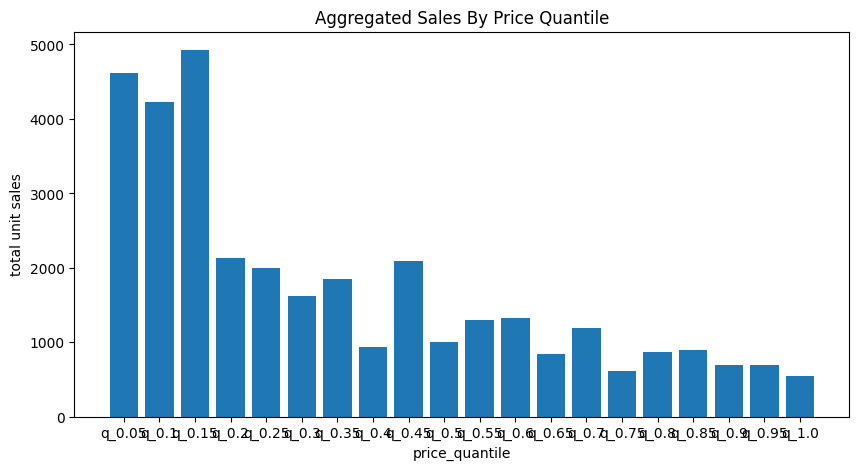

In [137]:
sales_by_price_quantile = df.groupby(['price_quantile', 'd'])['sold'].sum().reset_index(drop=False)#.sort_values("price_quantile", ascending=True)
sales_by_price_quantile = sales_by_price_quantile.groupby(['price_quantile'])['sold'].mean().reset_index(drop=False)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.bar(sales_by_price_quantile.price_quantile, sales_by_price_quantile.sold)
ax.set_title("Aggregated Sales By Price Quantile")
ax.set_xlabel("price_quantile")
ax.set_ylabel("total unit sales")
plt.show()

### Autocorrelation Plots 

In [151]:
res = df.groupby('id')['sold'].sum().sort_values()
res = res[res.index[::-1]]

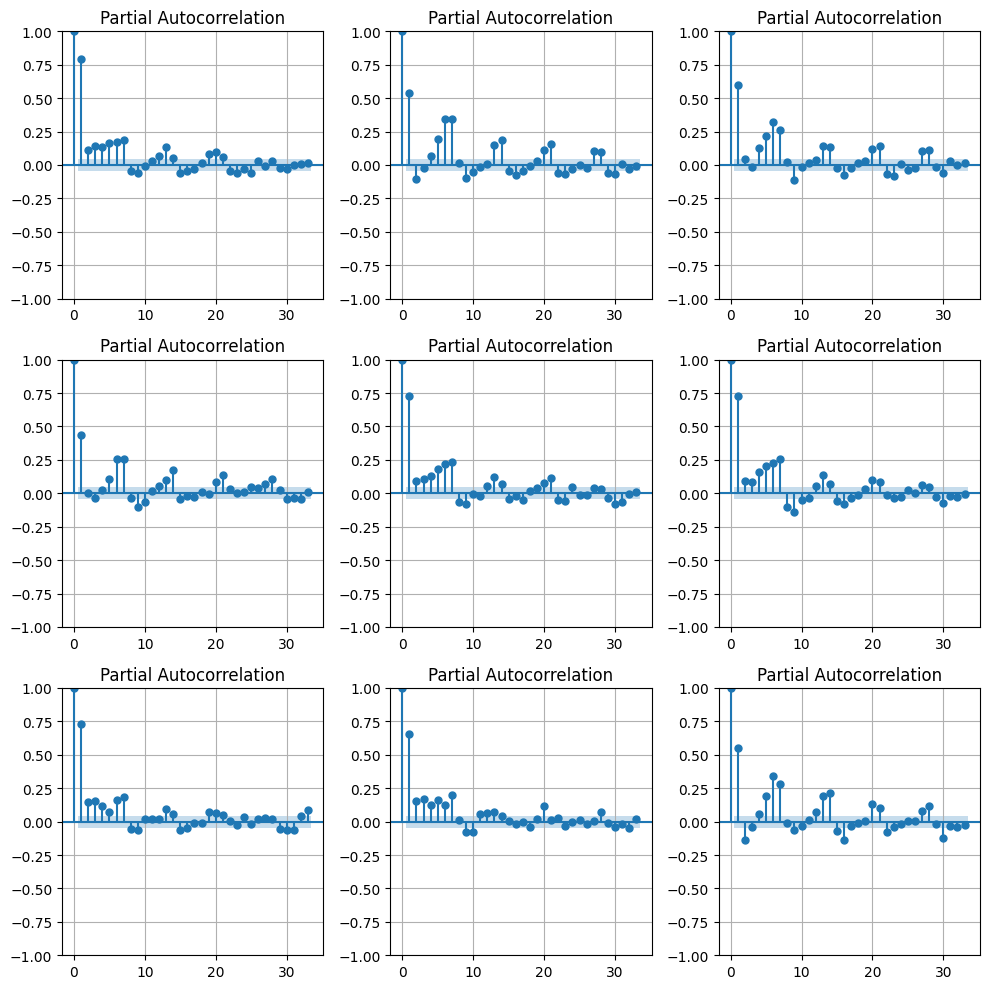

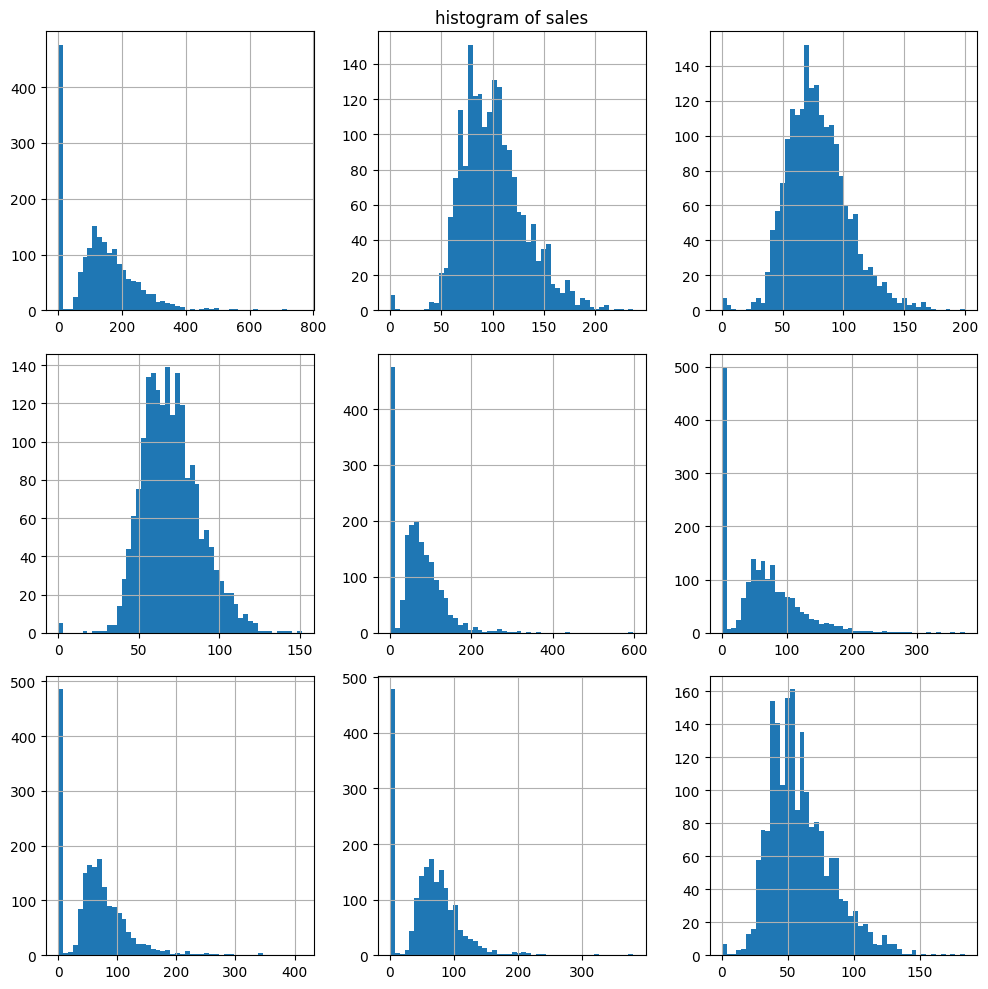

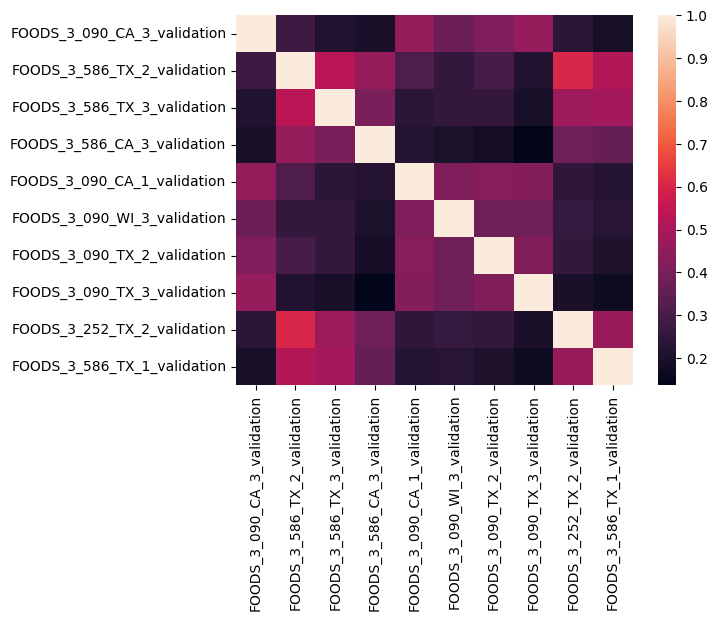

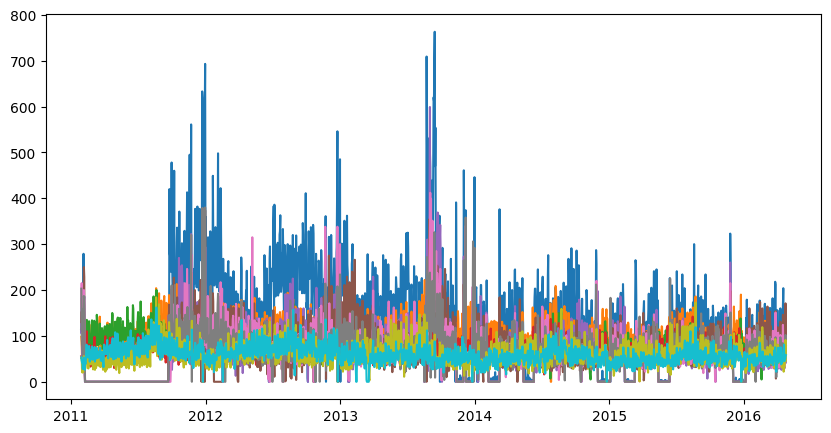

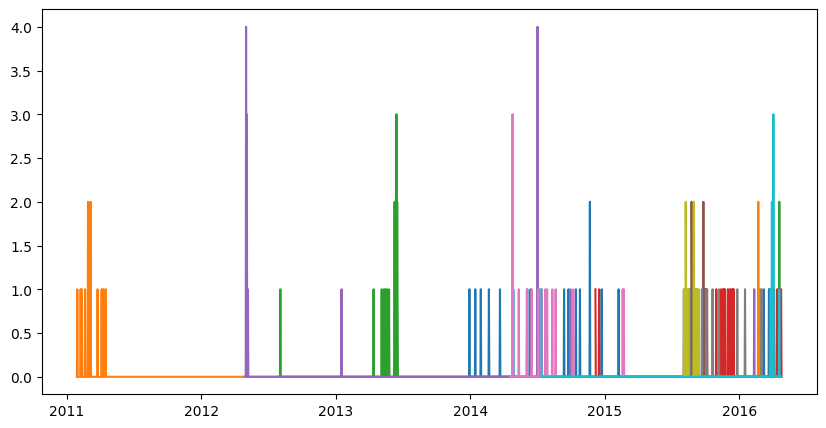

In [166]:
n = 3
m = 3
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    ax.grid()
    plot_pacf(df[df["id"] == res.index[k]]["sold"].dropna(), ax = ax)
fig.tight_layout()
plt.show()

n = 3
m = 3
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    ax.hist(df[df["id"] == res.index[k]]["sold"].dropna(), bins = 50)
    ax.grid()
axs[0,1].set_title("histogram of sales")
fig.tight_layout()
plt.show()

n = 10
sns.heatmap(pd.DataFrame(dict(zip(
    res.index[:n], 
    [
        df[df["id"] == id]["sold"].diff().dropna().values 
        for id in res.index[:n]
    ]
))).corr())
plt.show()

###